In [2]:
import pandas as pd
import numpy as np

ARIMA -> p,d,q

SARIMA -> (p,d,q) (P, D, Q)m

> P,D,Q,M are seasonal components' representation


1. P : Seasonal Regression
2. D : Seasonal Differencing
3. Q : Seasonal MA coeff
4. m : no. of datapoints per season / seasonal periods

> SARIMAX is sarima's implementation in statmodels, where <b>X = Exogeous Regressor Variables are also supported </b>

here we're just looking at SARIMA w/o exogenous part rn.

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# importing specific forecasting tools for sarima

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [5]:
# to check for SEASONAL component

from statsmodels.tsa.seasonal import seasonal_decompose as sd

In [6]:
# to find SARIMA parameters' orders

from pmdarima import auto_arima

In [7]:
df = pd.read_csv('Data/co2_mm_mlo.csv')

In [8]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


see this dataset has separate columns for year & month.

we'll use these two to create single datetime-col and then make it the index.

1. add a new column 'Date' -> dataframe['Date']
2. use pd.to_datetime() to get a dtime64 obj
3. in the 2(func) pass a dict {year=df['yearcolumn'] , month=df['monthcolumn'], day=df['daycolumn']}

In [9]:
# making a new column Date

#let it be day is 1 

df['Date'] = pd.to_datetime({'year' : df['year'],
                             'month' : df['month'], 
                             'day':1})

In [10]:
df.head()

,year,month,decimal_date,average,interpolated,Date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
year            729 non-null int64
month           729 non-null int64
decimal_date    729 non-null float64
average         722 non-null float64
interpolated    729 non-null float64
Date            729 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.2 KB


In [12]:
# see Date column is a datetime64 object

In [13]:
# to make Date the index

df.set_index('Date', inplace=True)

In [14]:
df.head()

,year,month,decimal_date,average,interpolated
Date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [15]:
# to use statsmodels

df.index.freq = 'MS'

you see that 'average' column has some NaN, so they've interpolated that value in the 'interpolated' column. so we'll use 'interpolated' instead where there's no missing points.

In [16]:
from matplotlib.pyplot import rcParams

rcParams['figure.figsize'] = (12,5)

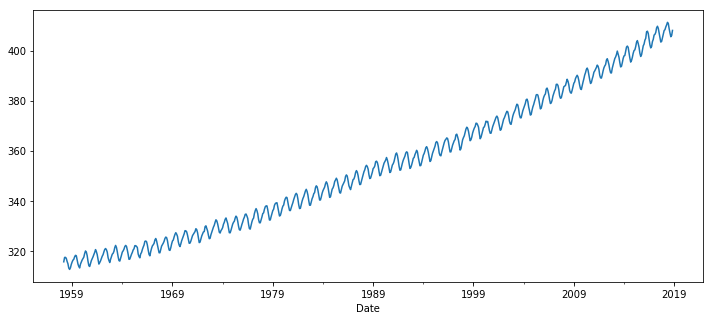

In [17]:
df['interpolated'].plot();

we've some visible seasonality. To confirm it & GET THE EXACT VALUE OF 'm' OR THE SEASONAL PERIODS, use ETS-Decomposition here.

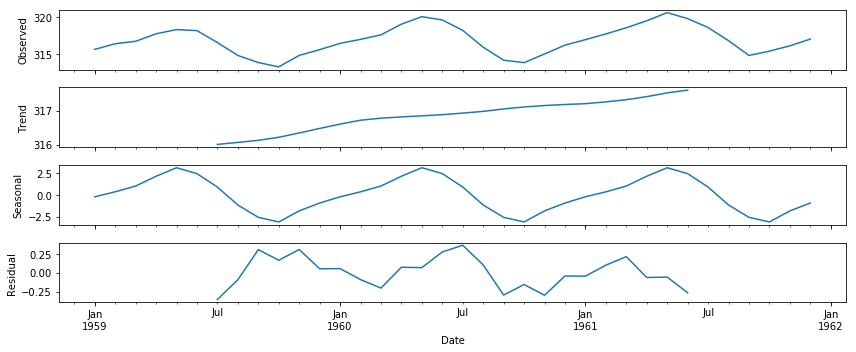

In [25]:
sd(df.loc['1959' : '1961','interpolated'], model='add').plot();

see that the seasonal definity has an impact so we'll use SARIMA.

> i zoomed in to just two years above to get the exact value of 'm' ie the SEASONAL PERIODS

as you can see 1 unit = 1 month & hence 1 season = 12 units = 12 months

=> m = 12 (as data has monthly units)

In [30]:
# finding orders using grid search

auto_arima(df['interpolated'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -207.462
Date:                            Sat, 21 Aug 2021   AIC                            424.925
Time:                                    01:55:14   BIC                            447.876
Sample:                                         0   HQIC                           433.781
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      1.044      0.296      -0.001       0.002
ma.L1         -0.3803      0.034    -11.130      0.000      -0.447      -0.313
ar.S.L12       0.9995      0.000   3054.231      0.000       0.999       1.000
ma.S.L12      -0.8631      0.022    -39.883      0.000      -0.906      -0.821
sigma2         0.0964      0.005     20.353      0.000       0.087       0.106
===================================================================================
Ljung-Box (Q):                       52.16   Jarque-Bera (JB):                 3.68
Prob(Q):                              0.09   Prob(JB):                         0.16
Heteroskedasticity (H):               1.11   Skew:                            -0.04
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

so we've got above is the values of p,d,q,P,D,Q :

> SARIMAX(0,1,1) X (1,0,1,12)

we had to pass seasonal=True & m=12 in auto_Arima() too.

## train & test split  and evaluating

1 year for testing

1. split
2. create on train
3. fit on train
4. predict test
5. evaluate actual vs preds

In [31]:
len(df)

729

In [32]:
len(df) - 12

717

In [33]:
train = df.iloc[: 717]

test = df[717 :]

In [34]:
# create

model = SARIMAX(train['interpolated'], order=(0,1,1) , seasonal_order=(1,0,1,12))

In [35]:
# fit 

fitted_model = model.fit()

In [37]:
fitted_model.summary()

# results similar to that of auto_arima()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.149
Date:                            Sat, 21 Aug 2021   AIC                            418.298
Time:                                    02:32:01   BIC                            436.593
Sample:                                03-01-1958   HQIC                           425.363
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3702      0.034    -10.796      0.000      -0.437      -0.303
ar.S.L12       0.9997      0.000   3173.007      0.000       0.999       1.000
ma.S.L12      -0.8648      0.023    -37.719      0.000      -0.910      -0.820
sigma2         0.0959      0.005     20.279      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       52.01   Jarque-Bera (JB):                 3.77
Prob(Q):                              0.10   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
# predicting test

start = len(train)

end = len(train) + len(test) - 1

preds = fitted_model.predict(start,end, typ='levels').rename('SARIMA preds')

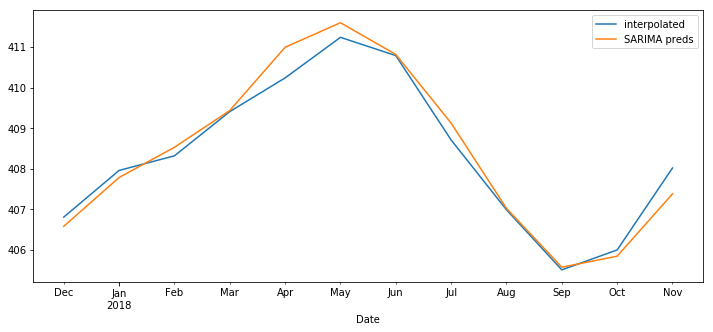

In [39]:
# plotting test actual vs preds

test['interpolated'].plot(legend=True, figsize=(12,5));

preds.plot(legend=True);

it performs pretty good on unseen data.

preds are v close to actual values.

In [40]:
# evaluation metrics

from statsmodels.tools.eval_measures import rmse

error = rmse( test['interpolated'], preds)

In [41]:
error

0.34614934181389595

In [43]:
test['interpolated'].mean()

408.3333333333333

error is quite negligible. 

## retraining model on full data 

In [44]:
fin_mod = SARIMAX(df['interpolated'], order=(0,1,1), seasonal_order=(1,0,1,12))

fit_fin_mod = fin_mod.fit()                  

In [50]:
# forecasting into future

# 12 months ahead

start = len(df)   #coz last data index is len-1

end = start + 11

fp = fit_fin_mod.predict(start, end, typ='levels').rename('SARIMA forecasta')

df.tail()  # last month nov2018

# first pred = dec2018

,year,month,decimal_date,average,interpolated
Date,,,,,
2018-07-01,2018,7,2018.542,408.71,408.71
2018-08-01,2018,8,2018.625,406.99,406.99
2018-09-01,2018,9,2018.708,405.51,405.51
2018-10-01,2018,10,2018.792,406.00,406.00
2018-11-01,2018,11,2018.875,408.02,408.02


In [51]:
len(fp)

12

plot forecasts vs original data

(only way to see how good it is)(idk advanced things rn)

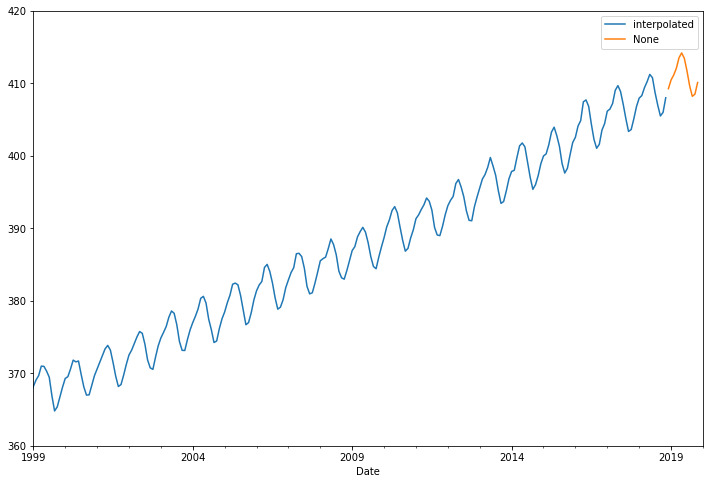

In [58]:
# plotting df vs finalpreds

df['interpolated'].plot(xlim = ['1999', '2020'], ylim=[360,420],legend=True, figsize=(12,8));

fp.plot(legend=True);

see the SARIMA model is doing pretty well here. 


> i zoomed in using xlim , ylim in plot() . first plot basic and then put xlim, ylim acc to xticks & yticks